In [1]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np
import random
import math

In [2]:
# method to load MNIST dataset


def load_minst(minst_dataset):
    data_dict = {}

    for file_name in minst_dataset:
        if file_name.endswith('ubyte'):
            with open(file_name, 'rb') as f:
                data = f.read()
                type = get_int(data[:4])
                length = get_int(data[4:8])
                if (type == 2051):
                    category = 'images'
                    num_rows = get_int(data[8:12])
                    num_cols = get_int(data[12:16])
                    parsed = np.frombuffer(data, dtype=np.uint8, offset=16)
                    parsed = parsed.reshape(length, num_rows, num_cols)
                elif (type == 2049):
                    category = 'labels'
                    parsed = np.frombuffer(data, dtype=np.uint8, offset=8)
                    parsed = parsed.reshape(length)
                if (length == 10000):
                    set = 'test'
                elif (length == 60000):
                    set = 'train'
                data_dict[set + '_' + category] = parsed

    return data_dict


def get_int(byte):
    return int.from_bytes(byte, "big")


mints_dataset_file_names = ["train-images.idx3-ubyte", "train-labels.idx1-ubyte", "t10k-images.idx3-ubyte",
                                "t10k-labels.idx1-ubyte"]

mnist_dict = load_minst(mints_dataset_file_names)


In [3]:
# Preparing train, test split

train_images = np.copy(mnist_dict['train_images'])
train_labels = np.copy(mnist_dict['train_labels']).astype('float32')
test_images = np.copy(mnist_dict['test_images'])
test_labels = mnist_dict['test_labels']


# converting to 28*28 images to 1-d array

train_images = np.reshape(train_images, (train_images.shape[0], train_images.shape[1] * train_images.shape[2]))
test_images = np.reshape(test_images, (test_images.shape[0], test_images.shape[1] * test_images.shape[2]))



In [4]:
# get class length, dimensions length, 
classes_length = len(np.unique(train_labels))
dimensions = len(train_images[0])
n = len(train_images)
# initialize weights array
weights = np.zeros([classes_length, dimensions])
# give random weights between range -0.01,0.01

def prepare_weights():
    
    for i in range(classes_length):
        for j in range(dimensions):
            rd = random.uniform(-0.01,0.01)
            weights[i][j] = rd
        
    return weights


print(weights.shape)


(10, 784)


In [5]:
train_images_norm = np.copy(train_images) / 255


In [6]:
def compute_confusion_matrix(true, pred):
    K = len(np.unique(true))  # Number of classes
    result = np.zeros((K, K))

    for i in range(len(true)):
        result[true[i]][pred[i]] += 1

    return result

In [52]:
def report_acc(conf_matrix, n):
    total = 0
    length = len(conf_matrix)
    for i in range(length):
        total = total + conf_matrix[i][i]
        
    return (total / n) * 100
    

In [53]:
def draw_conf_matrix(conf_matrix, slp, train, h):
   classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]

   fig, ax = plt.subplots()
   im = ax.imshow(conf_matrix)

   ax.set_xticks(np.arange(len(classes)))
   ax.set_yticks(np.arange(len(classes)))
   # ... and label them with the respective list entries
   ax.set_xticklabels(classes)
   ax.set_yticklabels(classes)

   plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

   for i in range(len(classes)):
       for j in range(len(classes)):
           text = ax.text(j, i, conf_matrix[i, j],
                          ha="center", va="center", color="w")

   if slp and train:
       acc = report_acc(conf_matrix, 60000)
       ax.set_title("Confusion matrix of the highest accuracy reached on train set\n single layer perceptron\n accuracy= %" + str(acc))
   if slp and not train:
       acc = report_acc(conf_matrix, 10000)
       ax.set_title("Confusion matrix of the highest accuracy reached on test set\n single layer perceptron\n accuracy= %" + str(acc))
   if not slp and train:
       acc = report_acc(conf_matrix, 60000)
       ax.set_title("Confusion matrix of the highest accuracy reached on train set\n multi layer perceptron\n h= " + str(h) + '\n accuracy= %' + str(acc))
   if not slp and not train:
       acc = report_acc(conf_matrix, 10000)
       ax.set_title("Confusion matrix of the highest accuracy reached on test set\n multi layer perceptron\n h= " + str(h) + '\n accuracy= %' + str(acc))

   fig.tight_layout()
   plt.show()

In [8]:
epocs_count = 50

def train_slp(epocs_count):
    epoc = 0
    weights = prepare_weights()
    best_weights = np.zeros([classes_length, dimensions])
    accs = []
    errs = []
    mses = []
    highest_acc = 0
    highest_acc_conf_matrix = []


    while epoc < epocs_count:

        orig = weights 

        d_w = np.zeros([classes_length, dimensions])

        correct_scores = 0
        predictions = []

        for t in range(n):
            
            o = np.zeros(classes_length)

            input_x = train_images_norm[t]
            x_label = train_labels[t].astype('int32')
            labels = np.zeros(classes_length)
            labels[x_label] = 1


            for i in range(classes_length):
                dot_product = np.dot(input_x, weights[i])
                o[i] = o[i] + dot_product

            y = np.zeros(classes_length)

            for i in range(classes_length):
                top = np.exp(o[i])
                bottom = np.sum(np.exp(o))
                y[i] = top / bottom

            predicted = np.argmax(y)
            predictions.append(predicted)

            if predicted == x_label:
                correct_scores = correct_scores + 1

            for i in range(classes_length):

                difference = labels[i] - y[i]
                d_w[i] = d_w[i] + np.dot(difference, input_x) 

        weights = weights + 0.0001 * d_w

        acc = (correct_scores/n) * 100
        errors = np.sum(orig - weights)
        mse = ((orig - weights)**2).mean()
        accs.append(acc)
        errs.append(errors)
        mses.append(mse)
        if acc > highest_acc:
            highest_acc_conf_matrix = compute_confusion_matrix(train_labels.astype('int32'), predictions)
            highest_acc = acc
            best_weights = weights
            print('best weights has been changed')

        print('epoc= ' + str(epoc) + '\t' + ' accuracy= ' + str(acc) + '\t' + 'error= ' + str(errors) + ' mse= ' + str(mse) + '\n')

        epoc = epoc + 1
        
    return best_weights, highest_acc_conf_matrix, accs, errs, mses

In [9]:
epocs_count = 50

best_weights_slp, highest_acc_conf_matrix_slp, accs_slp, errs_slp, mse_slp = train_slp(epocs_count)

best weights has been changed
epoc= 0	 accuracy= 7.539999999999999	error= 4.529709940470639e-14 mse= 0.004958350086722325

best weights has been changed
epoc= 1	 accuracy= 68.28666666666666	error= -1.3500311979441904e-13 mse= 0.005525436671244746

epoc= 2	 accuracy= 32.295	error= -7.759126674500294e-12 mse= 0.08190585019426753

epoc= 3	 accuracy= 47.69166666666666	error= -4.774847184307873e-12 mse= 0.028663512877708637

epoc= 4	 accuracy= 35.62166666666667	error= -5.3717030823463574e-12 mse= 0.05350518242750099

epoc= 5	 accuracy= 44.335	error= -4.888534022029489e-12 mse= 0.02830025983345943

epoc= 6	 accuracy= 37.30833333333333	error= -6.508571459562518e-12 mse= 0.04713072624915912

epoc= 7	 accuracy= 56.88666666666666	error= -4.007461029686965e-12 mse= 0.014704365838389803

epoc= 8	 accuracy= 54.25333333333333	error= -5.137223979545524e-12 mse= 0.015707876318214617

epoc= 9	 accuracy= 56.09166666666666	error= -4.526157226791838e-12 mse= 0.018717726224048884

epoc= 10	 accuracy= 66.84

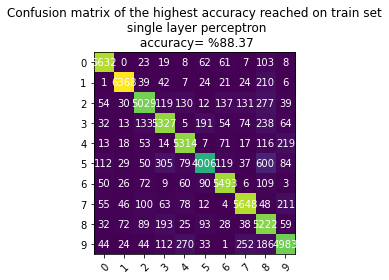

In [54]:
draw_conf_matrix(highest_acc_conf_matrix_slp.astype('int32'), True, True, h=0)

Text(0.5, 1.0, 'Single layer perceptron on training set')

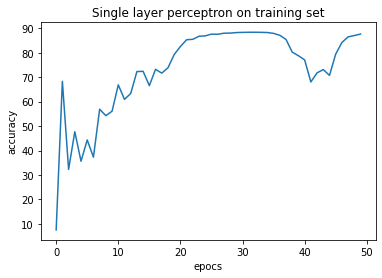

In [11]:
plt.plot(np.arange(0,50), accs_slp)
plt.xlabel('epocs')
plt.ylabel('accuracy')
plt.title('Single layer perceptron on training set')

Text(0.5, 1.0, 'Single layer perceptron on training set')

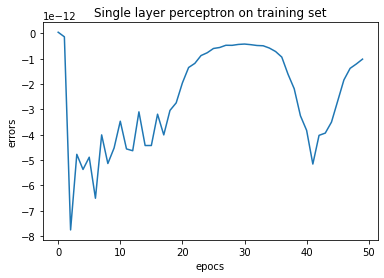

In [12]:
plt.plot(np.arange(0,50), errs_slp)
plt.xlabel('epocs')
plt.ylabel('errors')
plt.title('Single layer perceptron on training set')

Text(0.5, 1.0, 'Single layer perceptron on training set')

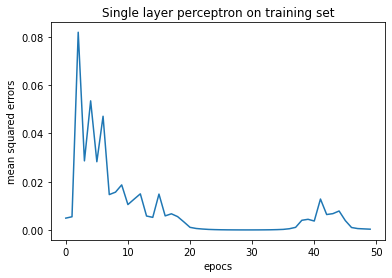

In [13]:
plt.plot(np.arange(0,50), mse_slp)
plt.xlabel('epocs')
plt.ylabel('mean squared errors')
plt.title('Single layer perceptron on training set')

In [14]:
test_images_norm = test_images / 255

In [15]:
def predict_slp(best_weights):
    
    n_test = len(test_images)

    predictions_test = []
    for t in range(n_test):
        x = test_images_norm[t]

        o = np.zeros(classes_length)
        for i in range(classes_length):
            dot_product = np.dot(x, best_weights[i])
            o[i] = o[i] + dot_product

        y = np.zeros(classes_length)

        for i in range(classes_length):
            top = np.exp(o[i])
            bottom = np.sum(np.exp(o))
            y[i] = top / bottom

        predicted = np.argmax(y)
        predictions_test.append(predicted)
        
    return predictions_test

            

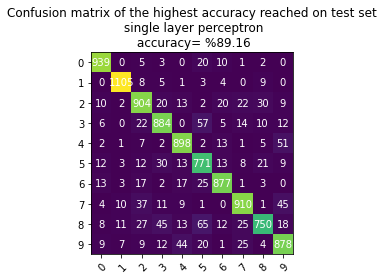

In [55]:
predictions_test = predict_slp(best_weights_slp)
    
confusion_matrix = compute_confusion_matrix(test_labels, predictions_test)

total = 0
for i in range(len(confusion_matrix)):
    total = total + confusion_matrix[i][i]
    

draw_conf_matrix(confusion_matrix.astype('int32'), True, False, h=0)

        

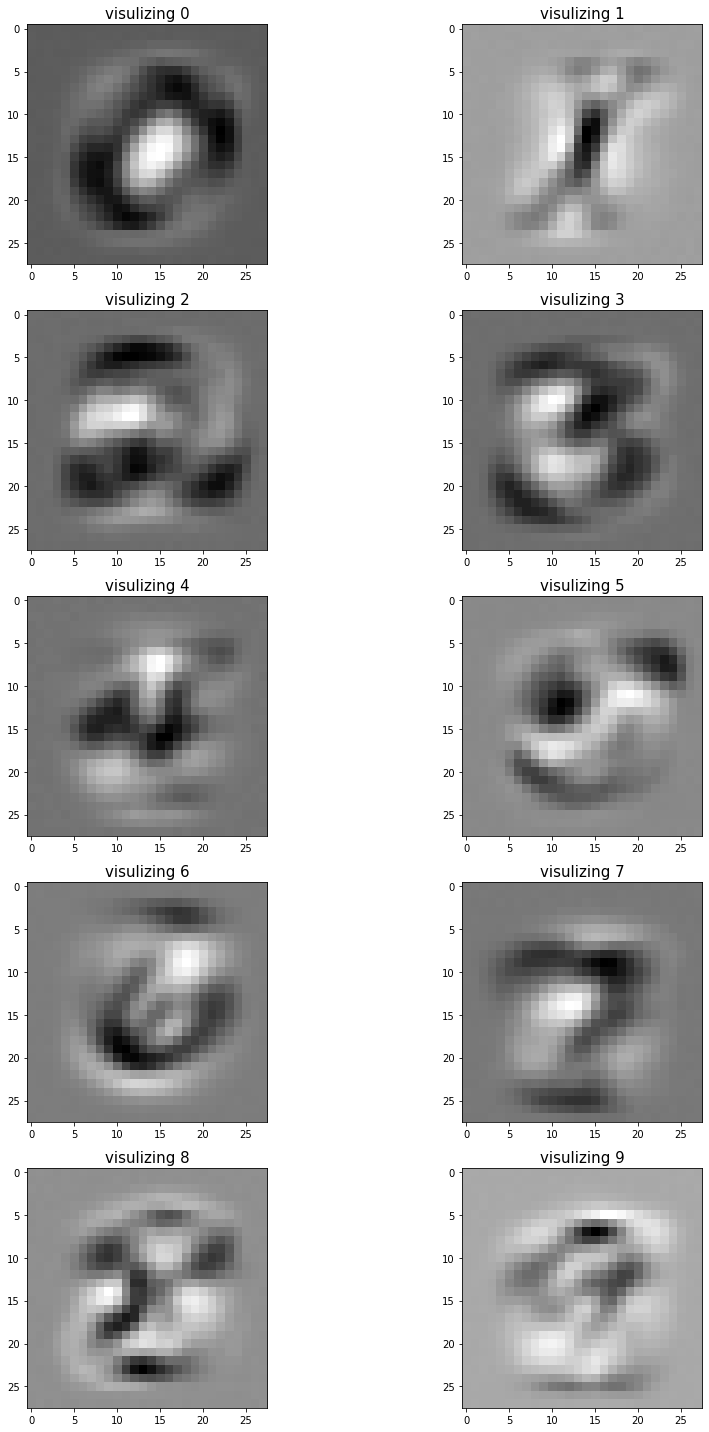

In [17]:
w=10
h=10

fig=plt.figure(figsize=(20, 20))
columns = 2
rows = 5
for i in range(1, columns*rows +1):
    img = best_weights_slp[i - 1].reshape(28,28)
    fig.add_subplot(rows, columns, i)
    plt.title('visulizing ' + str(i - 1), fontsize=(15))
    plt.imshow(img, cmap= 'binary')
    plt.tight_layout()

plt.show()

In [18]:
# initiliaze weights
h_len = 25

n_train = len(train_images)


def prepare_mlp_weights(h_len):
    
    w = np.zeros([h_len, dimensions])
    v = np.zeros([classes_length, h_len])
    
    for i in range(h_len):
        for j in range(dimensions):
            rd = random.uniform(-0.01,0.01)
            w[i][j] = rd

    for i in range(classes_length):
        for j in range(h_len):
            rd = random.uniform(-0.01,0.01)
            v[i][j] = rd
            
    return w, v



In [19]:
def train_mlp(epocs, h_len):
    
    w, v = prepare_mlp_weights(h_len)
    
    epoc = 0
    highest_acc = 0
    best_v = np.zeros([classes_length, h_len])
    best_w = np.zeros([h_len, dimensions])
    
    accs_mlp = []
    highest_acc_conf_matrix = []
    errors_v = []
    errors_w = []
    mses_v = []
    mses_w = []

    while epoc < epocs:
        correct_scores = 0
        predictions = []

        orig_v = v
        orig_w = w

        for t in range(n_train):


            x = train_images_norm[t]
            r_actual = train_labels[t].astype('int32')
            r = np.zeros(classes_length)
            r[r_actual] = 1

            z = np.zeros(h_len)
            for i in range(h_len):
                w_t = np.transpose(w[i])
                o = np.dot(w_t, x)
                sigmoid = 1 / (1 + np.exp(-o))
                z[i] = sigmoid

            y = np.zeros(classes_length)
            for i in range(classes_length):
                v_t = np.transpose(v[i])
                y[i] = np.dot(v_t,z)


            dis_v = np.zeros([classes_length, h_len])
            for i in range(classes_length):
                diff = r[i] - y[i]
                dis_v[i] = 0.001 * np.dot(diff, z)

            dis_w = np.zeros([h_len, dimensions])
            for h in range(h_len):
                sum_of = np.zeros(classes_length)
                for i in range(classes_length):
                    diff = r[i] - y[i]
                    sum_of[i] = diff * v[i][h]

                sum_total = np.sum(sum_of)
                inner_1 = np.dot(sum_total, z[h])
                inner_2 = np.dot(inner_1, 1 - z[h])
                inner_3 = np.dot(inner_2, x)
                dis_w[h] = 0.001 * inner_3

            predicted = np.argmax(y)
            predictions.append(predicted)
            if predicted == r_actual:
                correct_scores = correct_scores + 1

            v = v + dis_v
            w = w + dis_w

        error_v = np.sum(orig_v - v)
        error_w = np.sum(orig_w - w)
        mse_v = ((orig_v - v)**2).mean()
        mse_w = ((orig_w - w)**2).mean()

        errors_v.append(error_v)
        errors_w.append(error_w)
        mses_v.append(mse_v)
        mses_w.append(mse_w)

        acc = (correct_scores/n_train)*100
        accs_mlp.append(acc)

        if acc > highest_acc:
            highest_acc = acc
            best_v = v
            best_w = w
            highest_acc_conf_matrix = compute_confusion_matrix(train_labels.astype('int32'), predictions)
            print('highest accuracy has been changed')

        epoc = epoc + 1
        print('epoc= ' + str(epoc) + '\t' + 'accuracy= %' + str(acc) + '\t' + 'error v= ' + str(error_v) + '\terror w= ' + str(error_w))
        print('mse_v= ' + str(mse_v) + '\t' + 'mse_w= ' + str(mse_w) + '\n')
        
    return best_v, best_w, highest_acc_conf_matrix, errors_v, errors_w, mses_v, mses_w, accs_mlp

In [20]:
best_v_h_25, best_w_h_25, highest_acc_conf_matrix_h_25, errors_v_h_25, errors_w_h_25, mses_v_h_25, mses_w_h_25, accs_mlp_h_25 = train_mlp(20, 25)


highest accuracy has been changed
epoc= 1	accuracy= %41.123333333333335	error v= -2.3503070956935432	error w= 17.841917899507493
mse_v= 0.013591399724441946	mse_w= 0.0001612253893097735

highest accuracy has been changed
epoc= 2	accuracy= %76.19	error v= -0.015616700909839742	error w= 22.17555168249943
mse_v= 0.005527471549239804	mse_w= 9.836713346711257e-05

highest accuracy has been changed
epoc= 3	accuracy= %84.97666666666667	error v= 0.0224395201727475	error w= 20.78926501213217
mse_v= 0.0027219957443696636	mse_w= 6.266369552693355e-05

highest accuracy has been changed
epoc= 4	accuracy= %87.55666666666667	error v= 0.042028795169475525	error w= 19.12347388603015
mse_v= 0.001503876686366945	mse_w= 4.171590463009947e-05

highest accuracy has been changed
epoc= 5	accuracy= %88.70666666666666	error v= 0.0415983708546174	error w= 16.04900472127339
mse_v= 0.0010859686798965983	mse_w= 3.1004204491016436e-05

highest accuracy has been changed
epoc= 6	accuracy= %89.39833333333334	error v= 0

In [21]:
best_v_h_50, best_w_h_50, highest_acc_conf_matrix_h_50, errors_v_h_50, errors_w_h_50, mses_v_h_50, mses_w_h_50, accs_mlp_h_50 = train_mlp(20, 50)


highest accuracy has been changed
epoc= 1	accuracy= %46.21333333333333	error v= -2.0084456641241815	error w= 17.450351242918344
mse_v= 0.00749670430564345	mse_w= 9.335791245629696e-05

highest accuracy has been changed
epoc= 2	accuracy= %78.75333333333333	error v= -0.0024748115234359547	error w= 15.404689541118179
mse_v= 0.001907654598259447	mse_w= 4.121991329453213e-05

highest accuracy has been changed
epoc= 3	accuracy= %85.22833333333332	error v= 0.022844697157015287	error w= 11.94032945156672
mse_v= 0.0006807341232454425	mse_w= 2.4370478734414407e-05

highest accuracy has been changed
epoc= 4	accuracy= %86.80833333333334	error v= 0.02121371723186459	error w= 10.733380215844987
mse_v= 0.0005332143934424625	mse_w= 2.0342872098308322e-05

highest accuracy has been changed
epoc= 5	accuracy= %87.895	error v= 0.020104575379921386	error w= 9.723811323219753
mse_v= 0.0005160954939892437	mse_w= 1.845704231132747e-05

highest accuracy has been changed
epoc= 6	accuracy= %88.87166666666667	err

In [22]:
best_v_h_75, best_w_h_75, highest_acc_conf_matrix_h_75, errors_v_h_75, errors_w_h_75, mses_v_h_75, mses_w_h_75, accs_mlp_h_75 = train_mlp(20, 75)


highest accuracy has been changed
epoc= 1	accuracy= %47.97166666666667	error v= -2.089486697243511	error w= 16.46632742706876
mse_v= 0.0050907751406030705	mse_w= 6.419846253526844e-05

highest accuracy has been changed
epoc= 2	accuracy= %80.14166666666667	error v= 0.006704195599776391	error w= 7.092552450405047
mse_v= 0.0011871697725013835	mse_w= 2.5730935929503596e-05

highest accuracy has been changed
epoc= 3	accuracy= %85.35666666666667	error v= 0.011321928017074212	error w= 12.301960219474577
mse_v= 0.00028024069495951475	mse_w= 1.289820933432783e-05

highest accuracy has been changed
epoc= 4	accuracy= %86.57333333333334	error v= 0.005241683873887709	error w= 15.521821761830946
mse_v= 0.000242369771180399	mse_w= 1.1163160749919931e-05

highest accuracy has been changed
epoc= 5	accuracy= %87.58500000000001	error v= 0.006530287863311862	error w= 16.3496279980117
mse_v= 0.0002886031870837497	mse_w= 1.1583464807128173e-05

highest accuracy has been changed
epoc= 6	accuracy= %88.5466666

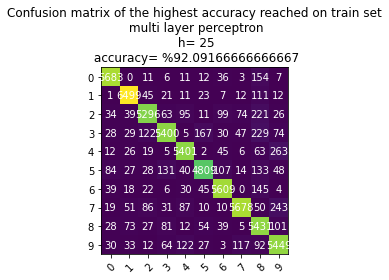

In [56]:
draw_conf_matrix(highest_acc_conf_matrix_h_25.astype('int32'), False, True, h=25)

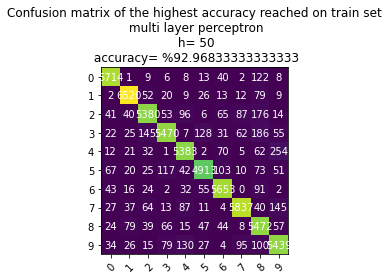

In [57]:
draw_conf_matrix(highest_acc_conf_matrix_h_50.astype('int32'), False, True, h=50)

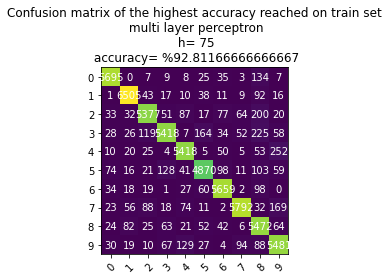

In [58]:
draw_conf_matrix(highest_acc_conf_matrix_h_75.astype('int32'), False, True, h=75)

([<matplotlib.axis.XTick at 0x197a14acbb0>,
 <a list of 10 Text major ticklabel objects>)

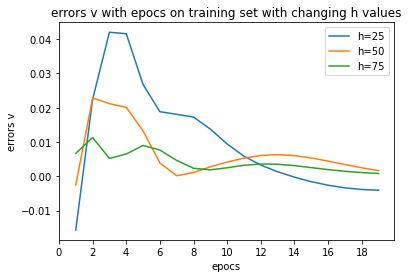

In [48]:
# starts after first epoc because to better see the differences

plt_1 = plt.plot(np.arange(1,20), errors_v_h_25[1:], label= 'h=25')
plt_2 = plt.plot(np.arange(1,20), errors_v_h_50[1:], label= 'h=50')
plt_3 = plt.plot(np.arange(1,20), errors_v_h_75[1:], label= 'h=75')

plt.xlabel('epocs')
plt.ylabel('errors v')
plt.title('errors v with epocs on training set with changing h values')
plt.legend()
plt.xticks(np.arange(0,20,2))

([<matplotlib.axis.XTick at 0x197a14445b0>,
 <a list of 10 Text major ticklabel objects>)

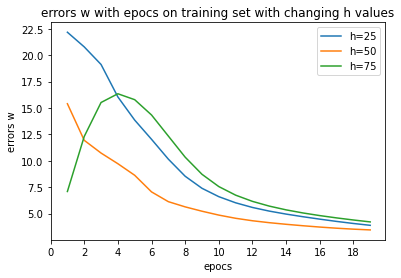

In [47]:
# starts after first epoc because to better see the differences


plt_1 = plt.plot(np.arange(1,20), errors_w_h_25[1:], label= 'h=25')
plt_2 = plt.plot(np.arange(1,20), errors_w_h_50[1:], label= 'h=50')
plt_3 = plt.plot(np.arange(1,20), errors_w_h_75[1:], label= 'h=75')

plt.xlabel('epocs')
plt.ylabel('errors w')
plt.title('errors w with epocs on training set with changing h values')
plt.legend()
plt.xticks(np.arange(0,20,2))

([<matplotlib.axis.XTick at 0x197a13d4bb0>,
 <a list of 10 Text major ticklabel objects>)

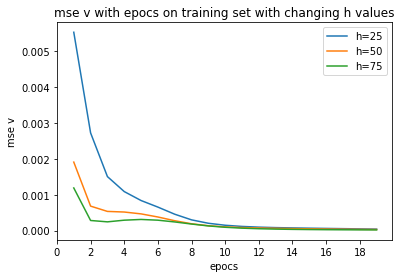

In [46]:
# starts after first epoc because to better see the differences


plt_1 = plt.plot(np.arange(1,20), mses_v_h_25[1:], label= 'h=25')
plt_2 = plt.plot(np.arange(1,20), mses_v_h_50[1:], label= 'h=50')
plt_3 = plt.plot(np.arange(1,20), mses_v_h_75[1:], label= 'h=75')

plt.xlabel('epocs')
plt.ylabel('mse v')
plt.title('mse v with epocs on training set with changing h values')
plt.legend()
plt.xticks(np.arange(0,20,2))

([<matplotlib.axis.XTick at 0x197a1369100>,
 <a list of 10 Text major ticklabel objects>)

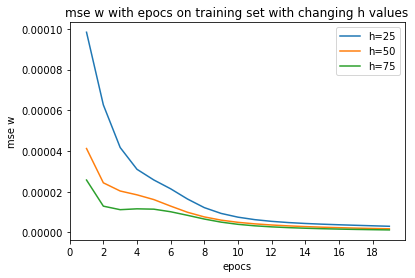

In [45]:
# starts after first epoc because to better see the differences


plt_1 = plt.plot(np.arange(1,20), mses_w_h_25[1:], label= 'h=25')
plt_2 = plt.plot(np.arange(1,20), mses_w_h_50[1:], label= 'h=50')
plt_3 = plt.plot(np.arange(1,20), mses_w_h_75[1:], label= 'h=75')

plt.xlabel('epocs')
plt.ylabel('mse w')
plt.title('mse w with epocs on training set with changing h values')
plt.legend()
plt.xticks(np.arange(0,20,2))

([<matplotlib.axis.XTick at 0x197a2037940>,
 <a list of 10 Text major ticklabel objects>)

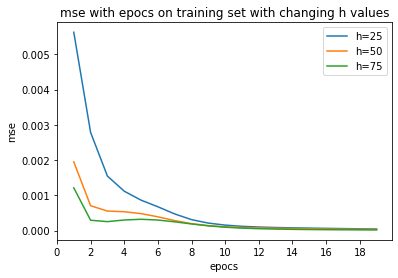

In [68]:
mse_h25_total = np.array(mses_w_h_25) + np.array(mses_v_h_25)
mse_h50_total = np.array(mses_w_h_50) + np.array(mses_v_h_50)
mse_h75_total = np.array(mses_w_h_75) + np.array(mses_v_h_75)


plt_1 = plt.plot(np.arange(1,20), mse_h25_total[1:], label= 'h=25')
plt_2 = plt.plot(np.arange(1,20), mse_h50_total[1:], label= 'h=50')
plt_3 = plt.plot(np.arange(1,20), mse_h75_total[1:], label= 'h=75')

plt.xlabel('epocs')
plt.ylabel('mse')
plt.title('mse with epocs on training set with changing h values')
plt.legend()
plt.xticks(np.arange(0,20,2))

([<matplotlib.axis.XTick at 0x197a12a0130>,
 <a list of 10 Text major ticklabel objects>)

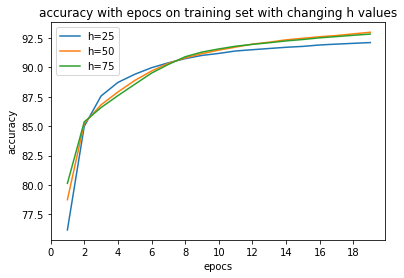

In [42]:
# starts after first epoc because to better see the differences


plt_1 = plt.plot(np.arange(1,20), accs_mlp_h_25[1:], label= 'h=25')
plt_2 = plt.plot(np.arange(1,20), accs_mlp_h_50[1:], label= 'h=50')
plt_3 = plt.plot(np.arange(1,20), accs_mlp_h_75[1:], label= 'h=75')

plt.xlabel('epocs')
plt.ylabel('accuracy')
plt.title('accuracy with epocs on training set with changing h values')
plt.legend()
plt.xticks(np.arange(0,20,2))

In [31]:
def predict_mlp(best_v, best_w, h_len):
    
    n_test = len(test_images)

    predictions_test = []
    for t in range(n_test):
        x = test_images_norm[t]

        z = np.zeros(h_len)
        for i in range(h_len):
            w_t = np.transpose(best_w[i])
            o = np.dot(w_t, x)
            sigmoid = 1 / (1 + np.exp(-o))
            z[i] = sigmoid

        y = np.zeros(classes_length)
        for i in range(classes_length):
            v_t = np.transpose(best_v[i])
            y[i] = np.dot(v_t,z)

        predicted = np.argmax(y)
        predictions_test.append(predicted)
        
    return predictions_test


In [32]:
predictions_test_h_25 = predict_mlp(best_v_h_25, best_w_h_25, 25)
predictions_test_h_50 = predict_mlp(best_v_h_50, best_w_h_50, 50)
predictions_test_h_75 = predict_mlp(best_v_h_75, best_w_h_75, 75)


confusion_matrix_h_25 = compute_confusion_matrix(test_labels, predictions_test_h_25)
confusion_matrix_h_50 = compute_confusion_matrix(test_labels, predictions_test_h_25)
confusion_matrix_h_75 = compute_confusion_matrix(test_labels, predictions_test_h_75)


total_h_25 = 0
total_h_50 = 0
total_h_75 = 0

for i in range(len(confusion_matrix)):
    total_h_25 = total_h_25 + confusion_matrix_h_25[i][i]
    total_h_50 = total_h_50 + confusion_matrix_h_50[i][i]
    total_h_75 = total_h_75 + confusion_matrix_h_75[i][i]

    
acc_h25 = (total_h_25 / len(test_images)) * 100
acc_h50 = (total_h_50 / len(test_images)) * 100
acc_h75 = (total_h_75 / len(test_images)) * 100



accuracy of the test images= %92.49000000000001


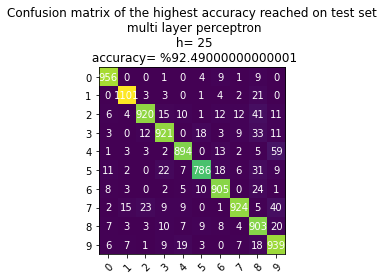

In [59]:

draw_conf_matrix(confusion_matrix_h_25.astype('int32'), False, False, h=25)

accuracy of the test images= %92.49000000000001


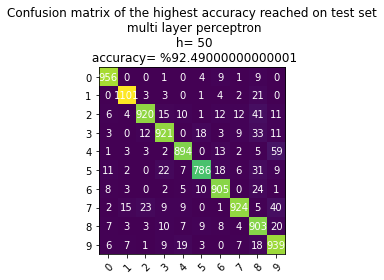

In [60]:

draw_conf_matrix(confusion_matrix_h_50.astype('int32'), False, False, h=50)

accuracy of the test images= %92.97


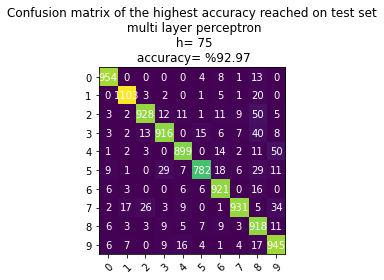

In [61]:
print('accuracy of the test images= %' + str(acc_h75))

draw_conf_matrix(confusion_matrix_h_75.astype('int32'), False, False, h=75)